In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import scipy.special as sp
import sklearn.datasets as datasets
import sklearn.linear_model as lm
import sklearn.ensemble as en
import sklearn.tree as tree
import econml

#### data generation packages
import strawman_edge
import strawman_center
import all_linear

#### main packages
import characterize

%load_ext jupyter_black

# Characterize Under-represented Population
1. Estimate CATE $\tau(x)$ and ATE $\tau$ for experimental sample
2. Estimate proclivity-score $P(S=1 \mid X=x)$ using both experimental and observational sample
3. Calculate heterogeneity-score $h(x) = (\tau(x) - \tau)^2$, and representation-score $r(x) = log P(S=1 \mid X=x) - log P(S=0 \mid X=x)$
4. Combine them using predefined weights $\alpha$ to calculate objective value $z(x) = \alpha_0 r(x) - \alpha_1 h(x)$
5. Learn a distance metric $M$ for K-NN that is smooth and predictive of $z$
6. Perform K-NN matching using $M$ on all samples and fetch their matched groups
7. Choose Q matched groups with smallest average $z$'s
8. Flag all the units in each of these matched groups
9. Learn a sparse decision tree that classifies flagged vs unflagged units. This tree explains which units are under-represented in experimental sample


## Experiments

### Strawman (Easy Mode) Example with under represented samples on edge
$P(S=1 \mid X) = expit( 0.25 - 2\left((X_0 > 0.5) (X_0 < 1) (X_1 > 0.5) (X_1 < 1)\right) )$ \
$Y(0) = 10 sin(\pi X_0 X_1) + 20 (X_2 - 0.5)^2 + 10 X_3 + 5 X_4 + \epsilon$ \
$Y(1) = Y(0) + log(Y(0) + 1)$

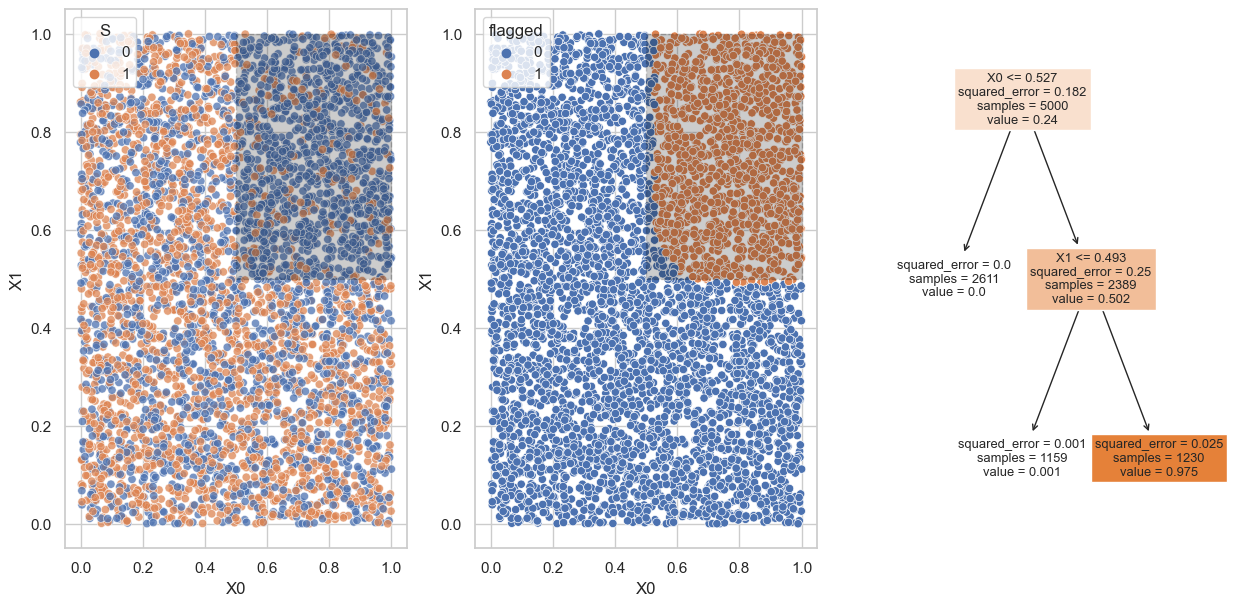

In [28]:
df, Y = strawman_edge.get_data(n=5000, seed=0)

#### plot scatter plot of X0 vs X1 and mark the region that is undersampled in experiment (truth)
sns.set(style="whitegrid")


alpha = [5, 1]
method = "match"
n_neighbors = 1200
p = 6
characterization_depth = 2
matched_groups, result, tau, M, df_result, m_tree = characterize.characterize(
    df, alpha=alpha, method=method, n_neighbors=n_neighbors, p=p
)

#### plot scatter plot of X0 vs X1 and mark the points in the region that is highlighted as undersampled in experiment (est)
fig, ax = plt.subplots(figsize=(15, 7), ncols=3)
sns.scatterplot(x="X0", y="X1", hue="S", data=df, alpha=0.75, ax=ax[0])
ax[0].add_patch(
    Rectangle((0.5, 0.5), 0.5, 0.5, color="black", ls="--", alpha=0.2, fill=True)
)
sns.scatterplot(
    x="X0",
    y="X1",
    hue="flagged",
    data=df_result,
    ax=ax[1],
)
ax[1].add_patch(
    Rectangle((0.5, 0.5), 0.5, 0.5, color="black", ls="--", alpha=0.2, fill=True)
)


#### characterization of the under-sampled space

plot_tree = tree.plot_tree(
    m_tree,
    filled=True,
    ax=ax[2],
    feature_names=df_result.drop(columns=["Yobs", "T", "S", "flagged"]).columns,
)

### Strawman (Hard Mode) Example with under represented samples in the middle
$P(S=1 \mid X) = expit( - 3\left((X_0 > 0.4) (X_0 < 0.6) (X_1 > 0.4) (X_1 < 0.6)\right) )$ \
$Y(0) = 10 sin(\pi X_0 X_1) + 20 (X_2 - 0.5)^2 + 10 X_3 + 5 X_4 + \epsilon$ \
$Y(1) = Y(0) + log(Y(0) + 1)$

In [31]:
df, Y = strawman_center.get_data(n=5000, seed=0)

#### plot scatter plot of X0 vs X1 and mark the region that is undersampled in experiment (truth)
sns.set(style="whitegrid")

alpha = [5, 1]
method = "match"
n_neighbors = 100
p = np.inf
characterization_depth = 2
smallest_k = 100

matched_groups, result, tau, M, df_result, m_tree = characterize.characterize(
    df, alpha=alpha, method=method, n_neighbors=n_neighbors, p=p
)

#### plot scatter plot of X0 vs X1 and mark the points in the region that is highlighted as undersampled in experiment (est)
fig, ax = plt.subplots(figsize=(15, 7), ncols=3)
sns.scatterplot(x="X0", y="X1", hue="S", data=df, alpha=0.75, ax=ax[0])
ax[0].add_patch(
    Rectangle((0.4, 0.4), 0.2, 0.2, color="black", ls="--", alpha=0.2, fill=True)
)

sns.scatterplot(
    x="X0",
    y="X1",
    hue="flagged",
    data=df_result,
    ax=ax[1],
)
ax[1].add_patch(
    Rectangle((0.4, 0.4), 0.2, 0.2, color="black", ls="--", alpha=0.2, fill=True)
)


#### characterization of the under-sampled space

plot_tree = tree.plot_tree(
    m_tree,
    filled=True,
    ax=ax[2],
    feature_names=df_result.drop(columns=["Yobs", "T", "S", "flagged"]).columns,
)

In [21]:
df, Y = strawman_center.get_data(n=5000, seed=0)

#### plot scatter plot of X0 vs X1 and mark the region that is undersampled in experiment (truth)
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x="X0", y="X1", hue="S", data=df, alpha=0.75, ax=ax)
ax.add_patch(
    Rectangle((0.4, 0.4), 0.2, 0.2, color="black", ls="--", alpha=0.2, fill=True)
)

alpha = [100, 0]
method = "match"
n_neighbors = 10
p = np.inf
characterization_depth = 3
smallest_k = 100
matched_groups, result, tau, M, df_result, m_tree = characterize.characterize(
    df,
    alpha=alpha,
    method=method,
    n_neighbors=n_neighbors,
    p=p,
    characterization_depth=characterization_depth,
    smallest_k=smallest_k,
)

#### plot scatter plot of X0 vs X1 and mark the points in the region that is highlighted as undersampled in experiment (est)
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x="X0", y="X1", data=df, alpha=0.75, ax=ax)
sns.scatterplot(
    x="X0",
    y="X1",
    hue="flagged",
    data=df_result,
    ax=ax,
)
ax.add_patch(
    Rectangle((0.4, 0.4), 0.2, 0.2, color="black", ls="--", alpha=0.2, fill=True)
)


#### characterization of the under-sampled space
fig, ax = plt.subplots(figsize=(10, 10))
plot_tree = tree.plot_tree(
    m_tree,
    filled=True,
    ax=ax,
    feature_names=df_result.drop(columns=["Yobs", "T", "S", "flagged"]).columns,
)

## All Linear

In [50]:
df, Y, coef = all_linear.get_data(n=5000, seed=0)

display(pd.DataFrame(coef, index=["coef. X%d" % (i) for i in range(20)]).T)

#### plot scatter plot of X0 vs X1 and mark the region that is undersampled in experiment (truth)
sns.set(style="whitegrid")

alpha = [
    10,
    0,
]  # we are only interested in identifying under sampled subpopulation and not in heterogeneity
method = "match"
n_neighbors = 100
p = 1
characterization_depth = 3
smallest_k = 100
matched_groups, result, tau, M, df_result, m_tree = characterize.characterize(
    df,
    alpha=alpha,
    method=method,
    n_neighbors=n_neighbors,
    p=p,
    characterization_depth=characterization_depth,
    smallest_k=smallest_k,
)

#### plot scatter plot of X0 vs X1 and mark the points in the region that is highlighted as undersampled in experiment (est)
fig, ax = plt.subplots(figsize=(10, 8), ncols=2, nrows=2)
sns.scatterplot(x="X4", y="X6", hue="S", data=df, alpha=0.75, ax=ax[0, 0])
sns.scatterplot(
    x="X4",
    y="X6",
    hue="flagged",
    data=df_result,
    ax=ax[0, 1],
)

gs = ax[1, 0].get_gridspec()
for axs in ax[1, :]:
    axs.remove()
axbig = fig.add_subplot(gs[1, :])

#### characterization of the under-sampled space
plot_tree = tree.plot_tree(
    m_tree,
    filled=True,
    ax=axbig,
    feature_names=df_result.drop(columns=["Yobs", "T", "S", "flagged"]).columns,
)

coef. X0  coef. X1  coef. X2  coef. X3  coef. X4  coef. X5  \
selection           0.0  0.000000       0.0       0.0       1.0       0.0   
heterogeneity       0.0  0.693147       0.0       0.0       0.0       0.0   

               coef. X6  coef. X7  coef. X8  coef. X9  coef. X10  coef. X11  \
selection           1.0  0.000000       0.0       0.0        1.0        0.0   
heterogeneity       0.0  2.079442       0.0       0.0        0.0        0.0   

               coef. X12  coef. X13  coef. X14  coef. X15  coef. X16  \
selection            0.0        0.0        0.0       -1.0        0.0   
heterogeneity        0.0        0.0        0.0        0.0        0.0   

               coef. X17  coef. X18  coef. X19  
selection            1.0        0.0        0.0  
heterogeneity        0.0        0.0        0.0